In [135]:
import cv2
import pytesseract
import re
import imutils 
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import requests
import io
import json
import easyocr
from gingerit.gingerit import GingerIt
import pandas as pd
import pysbd
import language_tool_python
from textblob import TextBlob
from scipy.ndimage import interpolation as inter
from spellchecker import SpellChecker
from fp.fp import FreeProxy

In [136]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract.exe'
TESSDATA_PREFIX = r'C:\Program Files (x86)\Tesseract-OCR'
custom_config = 'eng'

def make_me_invisible():
    global proxy
    proxy1 = FreeProxy(timeout=1, rand=True, anonym=False).get()
    proxy2 = 'http://' 
    proxy = {proxy2 : proxy1}
    while len(proxy1) > 27:
        proxy1 = FreeProxy(timeout=1, rand=True, anonym=False).get()
        proxy2 = 'http://' 
        proxy = {proxy2 : proxy1}  
    return proxy

In [137]:
def preproces_image(
    image,
    *,
    kernel_size=15,
    crop_side=50,
    blocksize=35,
    constant=15,
    max_value=255,
):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bit = cv2.bitwise_not(gray)
    image_adapted = cv2.adaptiveThreshold(
        src=bit,
        maxValue=max_value,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=blocksize,
        C=constant,
    )
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    erosion = cv2.erode(image_adapted, kernel, iterations=2)
    return erosion[crop_side:-crop_side, crop_side:-crop_side]

def find_edges(image_preprocessed, *, bw_threshold=150, limits=(0.2, 0.15)):
    mask = image_preprocessed < bw_threshold
    edges = []
    for axis in (1, 0):
        count = mask.sum(axis=axis)
        limit = limits[axis] * image_preprocessed.shape[axis]
        index_ = np.where(count >= limit)
        _min, _max = index_[0][0], index_[0][-1]
        edges.append((_min, _max))
    return edges

def adapt_edges(edges, *, height, width):
    (x_min, x_max), (y_min, y_max) = edges
    x_min2 = x_min
    x_max2 = x_max + min(250, (height - x_max) * 10 // 11)
    # could do with less magic numbers
    y_min2 = max(0, y_min)
    y_max2 = y_max + min(250, (width - y_max) * 10 // 11)
    return (x_min2, x_max2), (y_min2, y_max2)

def crop1(image):
    image_preprocessed = preproces_image(image)
    height, width = image.shape[0:2]
    edges = find_edges(image_preprocessed)
    (x_min, x_max), (y_min, y_max) = adapt_edges(edges, height=height, width=width)
    image_cropped = image[x_min:x_max, y_min:y_max]
    return image_cropped

In [138]:
def crop2(img):
    #img = cv2.imread("test.png")
    blurred = cv2.blur(img, (3,3))
    canny = cv2.Canny(blurred, 50, 200)
    ## find the non-zero min-max coords of canny
    pts = np.argwhere(canny>0)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)
    ## crop the region
    cropped = img[y1:y2, x1:x2]
    return cropped

In [139]:
def crop3(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0) # Blur
    canny = cv2.Canny(blurred, 30, 150) # Canny
    contours = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    cv2.drawContours(canny, contours, -1, 255, 2)
    canny = 255 - canny
    # Get mask for floodfill
    thresh = cv2.threshold(canny, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    h, w = thresh.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    # Floodfill from point (0, 0)
    cv2.floodFill(thresh, mask, (0,0), 0)
    rects = [cv2.boundingRect(cnt) for cnt in contours]
    #Calculate the combined bounding rectangle points.
    top_x = min([x for (x, y, w, h) in rects])
    top_y = min([y for (x, y, w, h) in rects])
    bottom_x = max([x+w for (x, y, w, h) in rects])
    bottom_y = max([y+h for (x, y, w, h) in rects])
    #Draw the rectangle on the image for testing
    out = cv2.rectangle(img, (top_x, top_y), (bottom_x, bottom_y), (0, 255, 0), 2)
    cropped = img[top_y:bottom_y, top_x:bottom_x]
    return cropped

In [140]:
def tesrotate1(image, center = None, scale = 1.0):
    angle=360-int(re.search('(?<=Rotate: )\d+', pytesseract.image_to_osd(image)).group(0))
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

In [141]:
def tesrotate2(image):
    rot_data = pytesseract.image_to_osd(image)
    rot = re.search('(?<=Rotate: )\d+', rot_data).group(0)
    angle = float(rot)
    rotated = imutils.rotate_bound(image, angle)
    return rotated

In [142]:
def correct_skew1(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
              borderMode=cv2.BORDER_REPLICATE)

    return rotated

In [143]:
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle

def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

def correct_skew2(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

In [144]:
def cvrotation(original):
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    # threshold the image, setting all foreground pixels to
    # 255 and all background pixels to 0
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45: 
        angle = -(90 + angle)
    # otherwise, just take the inverse of the angle to make
    # it positive
    else:
        angle = -angle
    
    # rotate the image to deskew it
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

In [145]:
def string1(img):
    url_api = "https://api.ocr.space/parse/image"
    _, compressedimage = cv2.imencode(".jpg", img, [1, 90])
    file_bytes = io.BytesIO(compressedimage)
    result = requests.post(url_api, files = {"captcha.jpg": file_bytes}, data = {"apikey": "19b169c2cf88957"})
    result = result.content.decode()
    result = json.loads(result)
    #print(result)
    text_detected = result.get("ParsedResults")[0].get("ParsedText")
    return text_detected

In [146]:
def string2(img):
    text = pytesseract.image_to_string(img, lang='eng')
    return text

In [147]:
def handwritten(image):
    reader = easyocr.Reader(['en'],gpu = False) # load once only in memory.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpen = cv2.filter2D(gray, -1, sharpen_kernel)
    thresh = cv2.threshold(sharpen, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    r_easy_ocr=reader.readtext(thresh,detail=0)
    text_output=''
    for i in r_easy_ocr:
        text_output+=str(i)+" "
    return text_output

In [148]:
def runGinger(par):
    subsegment_re = r'[^;:\n•]+[;,:\n•]?\s*'
    segmentor = pysbd.Segmenter(language="en", clean=False)
    fixed = []
    for sentence in segmentor.segment(par):
        if len(sentence) < 300:
            fixed.append(GingerIt().parse(sentence)['result'])
        else:
            subsegments = re.findall(subsegment_re, sentence)
            if len(subsegments) == 1 or any(len(v) < 300 for v in subsegments):
                # print(f'Skipped: {sentence}') // No grammar check possible
                fixed.append(sentence)
            else:
                res = []
                for s in subsegments:
                    res.append(GingerIt().parse(s)['result'])
                fixed.append("".join(res))
    return " ".join(fixed)

In [149]:
def correct_text(text):
    tool = language_tool_python.LanguageTool('en-US')
    final_text = tool.correct(text)   
    return final_text

In [150]:
def correct_text2(data):
    b = TextBlob(data)
    corrected = b.correct()
    return corrected

In [151]:
spell = SpellChecker()
def spell_checker(data):
    words = []
    for word in data.split():
               words.append(word)
    # find those words that may be misspelled
    misspelled = words
    final_text=''
    new_words = []
    for word in misspelled:
        # Get the one `most likely` answer
        new_words.append(spell.correction(word))
    for i in new_words:
        final_text += str(i)+" "
        # Get a list of `likely` options
        #print(spell.candidates(word))
    return final_text

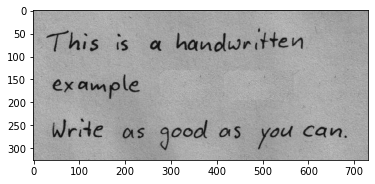

In [152]:
make_me_invisible()
image = cv2.imread(r"C:\Users\Admin\Desktop\multimodal\test\hand2.png")
plt.imshow(image)

In [153]:
image1 = crop1(image)
image2 = crop2(image)
image3 = crop3(image)

In [154]:
image4 = tesrotate1(image1)
image5 = tesrotate1(image2)
image6 = tesrotate1(image3)

In [155]:
image7 = tesrotate2(image1)
image8 = tesrotate2(image2)
image9 = tesrotate2(image3)

In [156]:
image10 = correct_skew1(image1)
image11 = correct_skew1(image2)
image12 = correct_skew1(image3)

In [157]:
image13 = correct_skew2(image1)
image14 = correct_skew2(image2)
image15 = correct_skew2(image3)

In [158]:
image16 = cvrotation(image1)
image17 = cvrotation(image2)
image18 = cvrotation(image3)

image19 = image #original image

In [159]:
for i in range(1,20,1):
    globals()[f"text{i}"] = string1(globals()[f"image{i}"])

In [160]:
j=1
for i in range(20,39,1):
    globals()[f"text{i}"] = string2(globals()[f"image{j}"])
    j=j+1

In [161]:
j=1
for i in range(40,59,1):
    globals()[f"text{i}"] = handwritten(globals()[f"image{j}"])
    j=j+1

Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with

In [162]:
maxlentext = text1
for i in range(2,39,1):
    prevlength = len(globals()[f"text{i-1}"]) # we compare each time the previous with the current and keep the one
    length = len(globals()[f"text{i}"])       # with the max length
    if length>prevlength:
        maxlentext=globals()[f"text{i}"]

In [163]:
maxlentext_hand = text40
for i in range(41,59,1):
    prevlength = len(globals()[f"text{i-1}"])
    length = len(globals()[f"text{i}"])
    if length>prevlength:
        maxlentext_hand=globals()[f"text{i}"]

In [164]:
print("Machine written extractor")
print(maxlentext)
print(" ")
print("Handwritten extractor")
print(maxlentext_hand)

Machine written extractor
his is oa hanoluritten

example

 

Wrije as goood as fad can


 
Handwritten extractor
Ths 15 4 hand Jr { tew ex ample Wrie MS Joo0 0 $ You can 


In [165]:
correct1 = runGinger(maxlentext)
correct5 = runGinger(maxlentext_hand)
print(correct1)
print(" ")
print(correct5)

He is a hanoluritten

 example

 

 Wrije as good as fad can


 
This 15 4 hand Jr {the example Wrie MS Joo0 0 $ You can 


In [166]:
correct2 = correct_text(maxlentext)
correct6 = correct_text(maxlentext_hand)
print(correct2)
print(" ")
print(correct6)

His is OA handwritten

example

 

Write as good as fad can


 
Th's 15 4 hand Jr {too ex ample Write MS Joo0 $0 You can 


In [167]:
correct3 = correct_text2(maxlentext)
correct7 = correct_text2(maxlentext_hand)
print(correct3)
print(" ")
print(correct7)

his is of hanoluritten

example

 

Rise as good as fad can


 
The 15 4 hand Or { new ex ample Erie of Room 0 $ You can 


In [168]:
correct4 = spell_checker(maxlentext)
correct8 = spell_checker(maxlentext_hand)
print(correct4)
print(" ")
print(correct8)

his is oa hanoluritten example write as goood as fad can 
 
the 15 4 hand or { tew ex ample write is joon 0 $ You can 


In [169]:
correct9 = maxlentext
correct10 = maxlentext_hand
print(correct9)
print(" ")
print(correct10)

his is oa hanoluritten

example

 

Wrije as goood as fad can


 
Ths 15 4 hand Jr { tew ex ample Wrie MS Joo0 0 $ You can 


In [170]:
print(string1(image)) 
print(" ")
print(string2(image))
print(" ")
print(handwritten(image))

-r his I's a havtolLJm++eL.n
IJrae as 00001 as you Can.

 


Using CPU. Note: This module is much faster with a GPU.


his is oa hanoluritten

example

 

Wrije as goood as fad can


 
Ths 15 4 hand Jr { tew ex ample Wrie MS Joo0 0 $ You can 
